# Creating an Autoencoder

This notebook explores the generation of autoencoder networks that trains on 27x27 pixel images of randomly generated circles. The autoencoders will be restricted to a use of no more than 30,000 randomly generated samples in order to compare the effects of the bottleneck size.



## Import Modules
Firstly, we need to import the modules necessary for our neural network training and cost function output.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

## Function definition
The functions defined below will allow us to turn a desired function into pixel image of a specified size, train our network on it, display our inputs and outputs and print out some important information about our network such as the layer sizes.

In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):

    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)

    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)

    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!

        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)

    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)

    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")

def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features

## Circle generator
The code cell below defines a function that will generate a circle that will be randomly placed in a pixel image of x*y dimension. We will use this to train our autoencoder.

In [4]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
  '''Defines a circle of random size which is randomly placed in an image of x*y pixels'''
  R=np.random.uniform(size=batchsize)
  x0=np.random.uniform(size=batchsize,low=-1,high=1)
  y0=np.random.uniform(size=batchsize,low=-1,high=1)
  return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## Our first autoencoder
Now we can define an autoencoder with 9 neurons in the bottleneck that will be trained on our circle image. This network will only consist of convolutional and pooling layers and uses the 'mean_squared_error' cost function.

In [5]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, 3, input_shape=(None, None, 1),
               activation="relu", padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3), padding='same')) # down
model.add(keras.layers.Conv2D(8,3, activation="relu", padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3), padding='same')) # down
model.add(keras.layers.Conv2D(1, 3, activation="relu", padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(8,3, activation="relu", padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(16, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(1, 3, activation="linear", padding='same'))
model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    160       
                                                                 
 average_pooling2d (Average  (None, None, None, 16)    0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     1160      
                                                                 
 average_pooling2d_1 (Avera  (None, None, None, 8)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     73        
                                                                 
 up_sampling2d (UpSampling2  (None, None, None, 1)     0

Time to train this network on the circle function and assess its performance in recreating the original image.

0.02163921482861042


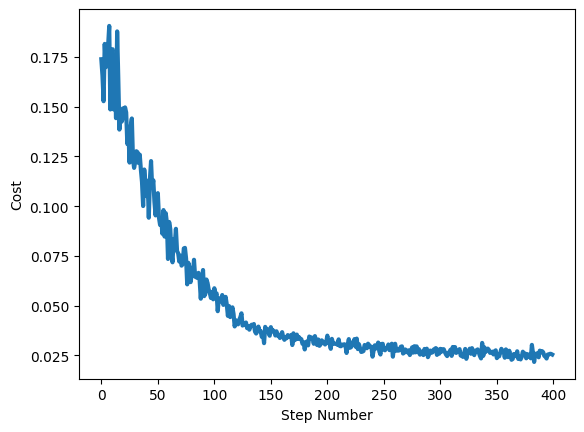

In [6]:
steps=400 # step
cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=75,steps=steps)
#Plot the cost function
fig, ax = plt.subplots()
stepArray=np.arange(steps) # sort steps into array
ax.plot(stepArray,cost,linewidth=3) # plot cost
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")
print(min(cost))

In [7]:
print_layers(model,y_target) # check the number of neurons in each layer of our network

Layer 0: 11664 neurons /  (75, 27, 27, 16)
Layer 1: 1296 neurons /  (75, 9, 9, 16)
Layer 2: 648 neurons /  (75, 9, 9, 8)
Layer 3: 72 neurons /  (75, 3, 3, 8)
Layer 4: 9 neurons /  (75, 3, 3, 1)
Layer 5: 81 neurons /  (75, 9, 9, 1)
Layer 6: 648 neurons /  (75, 9, 9, 8)
Layer 7: 5832 neurons /  (75, 27, 27, 8)
Layer 8: 11664 neurons /  (75, 27, 27, 16)
Layer 9: 729 neurons /  (75, 27, 27, 1)


## An even more condensed autoencoder
Great! A cost of less than 0.02 has been achieved with our autoencoder that has a bottleneck of 9 neurons. Let's see what happens if we try to bottleneck our network even more with only 3 neurons holding all the image information in the middle. Again, our network will only consist of convolutional and pooling layers.

In [8]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(32, 3, input_shape=(None, None, 1),
               activation="relu", padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3), padding='same')) # down
model2.add(keras.layers.Conv2D(16, 3, activation="relu", padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3), padding='same')) # down
model2.add(keras.layers.Conv2D(8,3, activation="relu", padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3), padding='same')) # down
model2.add(keras.layers.Conv2D(3, 3, activation="relu", padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(8, 3, activation="relu", padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(16, 3, activation="relu", padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(32, 3, activation="relu", padding='same'))
model2.add(keras.layers.Conv2D(1, 3, activation="linear", padding='same'))
model2.compile(loss='mean_squared_error',
              optimizer='adam')

And now to see how the cost function behaves with this even more condensed network.

Text(0, 0.5, 'Cost')

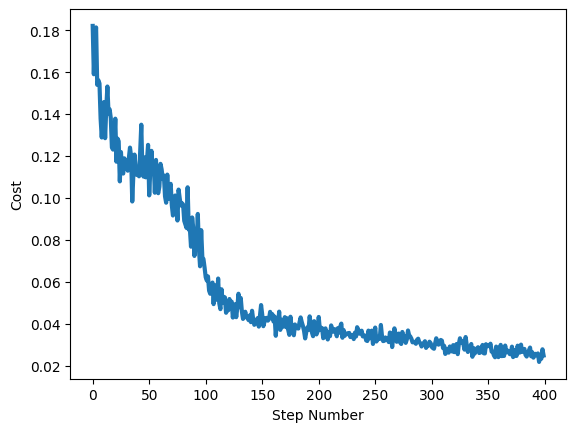

In [9]:
steps=400
cost,y_target=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=75,steps=steps) # train and get cost on 27x27 image
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) # sort steps into array
ax.plot(stepArray,cost,linewidth=3) # plot cost
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

In [11]:
print_layers(model2,y_target) # check number of neurons in layers of network

Layer 0: 23328 neurons /  (75, 27, 27, 32)
Layer 1: 2592 neurons /  (75, 9, 9, 32)
Layer 2: 1296 neurons /  (75, 9, 9, 16)
Layer 3: 144 neurons /  (75, 3, 3, 16)
Layer 4: 72 neurons /  (75, 3, 3, 8)
Layer 5: 8 neurons /  (75, 1, 1, 8)
Layer 6: 3 neurons /  (75, 1, 1, 3)
Layer 7: 27 neurons /  (75, 3, 3, 3)
Layer 8: 72 neurons /  (75, 3, 3, 8)
Layer 9: 648 neurons /  (75, 9, 9, 8)
Layer 10: 1296 neurons /  (75, 9, 9, 16)
Layer 11: 11664 neurons /  (75, 27, 27, 16)
Layer 12: 23328 neurons /  (75, 27, 27, 32)
Layer 13: 729 neurons /  (75, 27, 27, 1)


Our autoencoder with only 3 neurons in the bottleneck has proved to be quite effective in recreating the image with a cost as low as 0.02!

## Conclusion
It is easy to realise that a lower number of neurons in the bottleneck would cause the autoencoder's output to be worse, as expected because at that point those few neurons are holding all of the information of the original image meaning that a lot of the components would be lost. This is why to achieve such a low cost as we have done above, the network has been made a lot more complicated with many more total neurons than the original network with 9 in the bottleneck. This comes at the cost of computational power, as demonstrated by the second network taking a lot longer to train than the first. This may be worth the trade-off if one is aiming to maximally compress some images/data and the computational power/efficiency is not of much concern.